# Predicting K2-28b's and K2-100b's masses from their radii

In [4]:
from __future__ import print_function
import pandas as pd
import numpy as np
import datetime
import matplotlib.dates as mdates
import seaborn as sns; sns.set()
sns.set_context("poster",font_scale=1.2,rc={"font":"helvetica"});
sns.set_style("white"); #sns.set_style("ticks")
cp = sns.color_palette("colorblind") #sns.palplot(current_palette)
%matplotlib inline
%config InlineBackend.figure_format = "retina"
import matplotlib.pyplot as plt
import sys
sys.path.append("../src/")

import getpass
# Remove gks paths (not needed for anyone else)
if getpass.getuser()=="gks":
    try:
        sys.path.remove("/Users/gks/Dropbox/mypylib/notebooks/GIT/transitMCMC/src")
        sys.path.remove("/Users/gks/Dropbox/mypylib")
    except Exception as e:
        print(e)
        print("Paths already removed")
        
%matplotlib inline
%config InlineBackend.figure_format = "retina"
#%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}
#%config InlineBackend.print_figure_kwargs = {'bbox_inches':'tight'}


import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
#rcParams["text.usetex"] = True #uncomment to use tex. Slow, but pretty
#rcParams["font.weight"] = 900

rcParams['mathtext.fontset'] = 'stix'
rcParams['font.family'] = 'STIXGeneral'
rcParams['font.weight'] = "normal"
rcParams["axes.formatter.useoffset"] = False
rcParams['xtick.major.width']=1
rcParams['xtick.major.size']=7
rcParams['xtick.minor.width']=1
rcParams['xtick.minor.size']=4
rcParams['ytick.major.width']=1
rcParams['ytick.major.size']=7
rcParams['ytick.minor.width']=1
rcParams['ytick.minor.size']=4
#%matplotlib nbagg

list.remove(x): x not in list
Paths already removed


In [5]:
import corner
import astropy.constants as aconst
from scipy.stats import truncnorm 
from matplotlib import rcParams
import utils
import mr_forecast
# Will need to install Forecaster: https://github.com/chenjj2/forecaster

In [6]:
def predict_mass_from_radius_posterior(r_post=None,pl_rade=None,pl_radeerr1=None,sample_size=10000,classify="No",plot=True):
    """
    Use Forecaster from Chen & Kipping to estimate mass from radius. This function generates a radius posterior from
    a mean and std input value.
    
    INPUT:
        pl_rade      - planet radius in Earth radii
        pl_radeerr1  - planet radius error in Earth radii
        sample_size  - h

    OUTPUT:
        r_post       - radius posterior
        m_post       - mass posterior
    """
    if r_post is None:
        print("Generating posterior from mean and std")
        r_lower_bound = 1e-1 # Earth radii
        r_upper_bound = 1e2  # Earth radii
        r_post = truncnorm.rvs( (r_lower_bound-pl_rade)/pl_radeerr1, (r_upper_bound-pl_rade)/pl_radeerr1, loc=pl_rade,
                                 scale=pl_radeerr1, size=sample_size)
    else:
        print("Using supplied radius posterior")
        
    m_post = mr_forecast.Rpost2M(r_post, unit='Earth', grid_size=1e3, classify=classify)
        
    if plot:
        fig = corner.corner(np.vstack([r_post,m_post]).T,
                       labels=[r"$R_\oplus$", r"$M_\oplus$"],
                       quantiles=[0.16, 0.5, 0.84],
                       show_titles=True, title_kwargs={"fontsize": 12},lw=0.5,
                       hist_kwargs={"lw":0.5})

    return r_post, m_post

def get_predicted_rv_semiamplitude_posteriors(pl_rade,
                                              pl_radeerr1,
                                              pl_orbper,
                                              pl_orbincl,
                                              pl_orbecc,
                                              st_mass,
                                              xcord=(0.5,-0.2),
                                              ycord=(-0.2,0.5),
                                              labelsize=14,
                                              ticklabelsize=11):
    """
    Predicts the rv semiamplitude of a planet with a known radius, predicting the planet mass using Forecaster.
    
    INPUT:
        pl_rade      - planet radius in Earth radii
        pl_radeerr1  - error on planet radius in Earth radii
        pl_orbper    - planet orbital period in days
        pl_orbincl   - planet inclination in degrees
        pl_orbecc    - planet eccentricity
        st_mass      - mass of host star in solar masses
        
    OUTPUT:
        r_post  - Generated radius posterior from pl_rade and pl_radeerr1
        m_post  - predicted mass posteriror
        rv_post - estimated rv posterior
    """
    r_post, m_post = predict_mass_from_radius_posterior(pl_rade=pl_rade,pl_radeerr1=pl_radeerr1,plot=False)
    rv_post = utils.rv_semiamplitude(m_1=st_mass,
                                     m_2=m_post,
                                     P=pl_orbper,
                                     i=pl_orbincl,
                                     e=pl_orbecc)
    rcParams["lines.linewidth"] = 1.0
    rcParams["axes.labelpad"]   = 40.0
    rcParams["xtick.labelsize"] = ticklabelsize
    rcParams["ytick.labelsize"] = ticklabelsize
    rcParams["xtick.major.pad"] = 2
    rcParams["ytick.major.pad"] = 2
    
    fig = corner.corner(np.vstack([r_post,m_post,rv_post]).T,
                   labels=[r"$R_\oplus$", r"$M_\oplus$",r"RV (m/s)"],
                   quantiles=[0.16, 0.5, 0.84],
                   hist_kwargs={"lw":1.5},
                   show_titles=True, title_kwargs={"fontsize": labelsize},lw=1.,
                   label_kwargs={"fontsize":labelsize},
                   xlabcord=(xcord),
                   ylabcord=(ycord));
    return r_post, m_post, rv_post, fig

# K2-28b

Generating posterior from mean and std
Terran 0.0 %, Neptunian 100.0 %, Jovian 0.0 %, Star 0.0 %
Generating posterior from mean and std
Plotting cornerplot


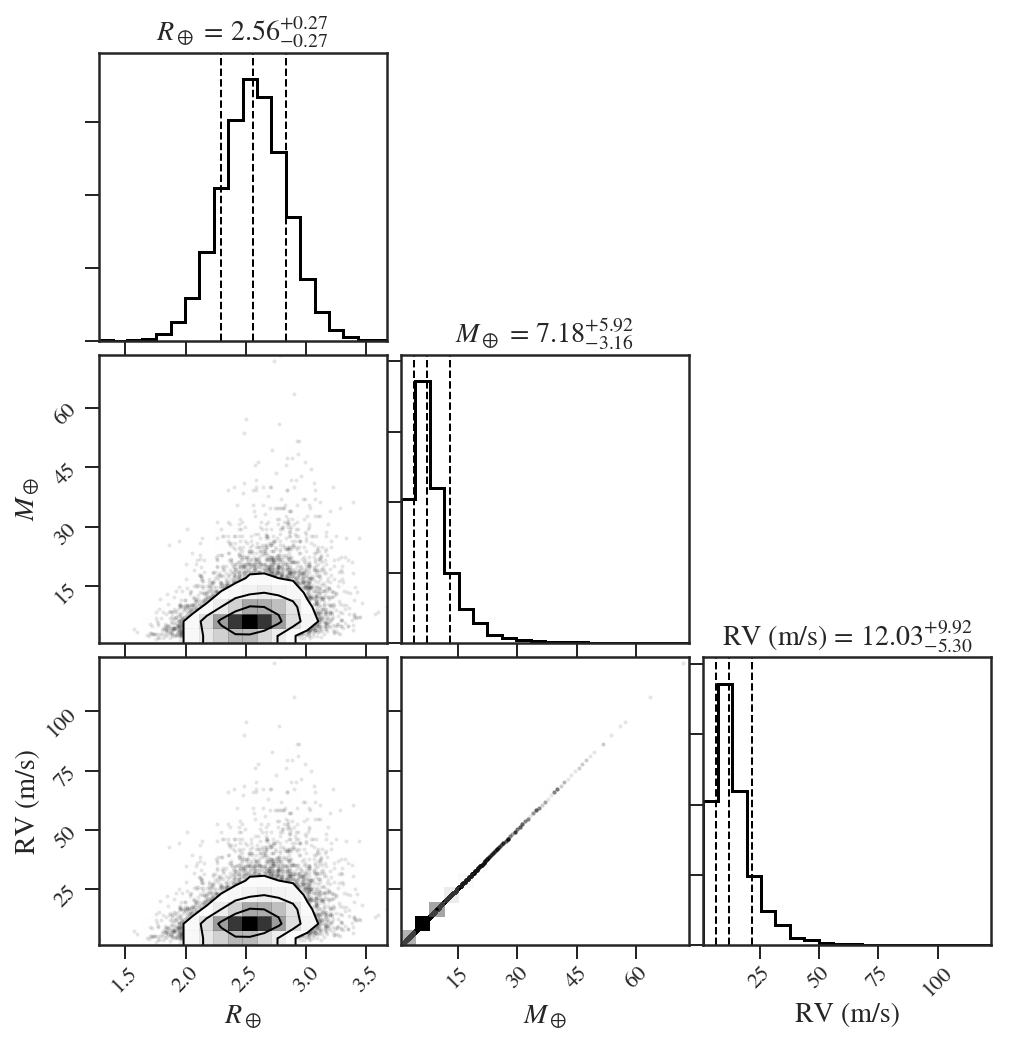

In [8]:
# K2-28b values
pl_rade      = 2.56
pl_radeerr1  = 0.27
pl_orbincl   = 87.1
pl_orbecc    = 0.
pl_orbper    = 2.2604455
st_mass      = 0.288

# Classify
r_post, m_post = predict_mass_from_radius_posterior(pl_rade=pl_rade, pl_radeerr1=pl_radeerr1,classify="Yes",plot=False)

# Generate RV posterior plot
r_post, m_post, rv_post, fig = get_predicted_rv_semiamplitude_posteriors(pl_rade=pl_rade,
                                          pl_radeerr1=pl_radeerr1,
                                          pl_orbper=pl_orbper,
                                          pl_orbincl=pl_orbincl,
                                          pl_orbecc=pl_orbecc,
                                          st_mass=st_mass)
#fig.suptitle("K2-28b",fontsize=16)

# K2-100b

Generating posterior from mean and std
Terran 0.0 %, Neptunian 100.0 %, Jovian 0.0 %, Star 0.0 %
Generating posterior from mean and std
Plotting cornerplot


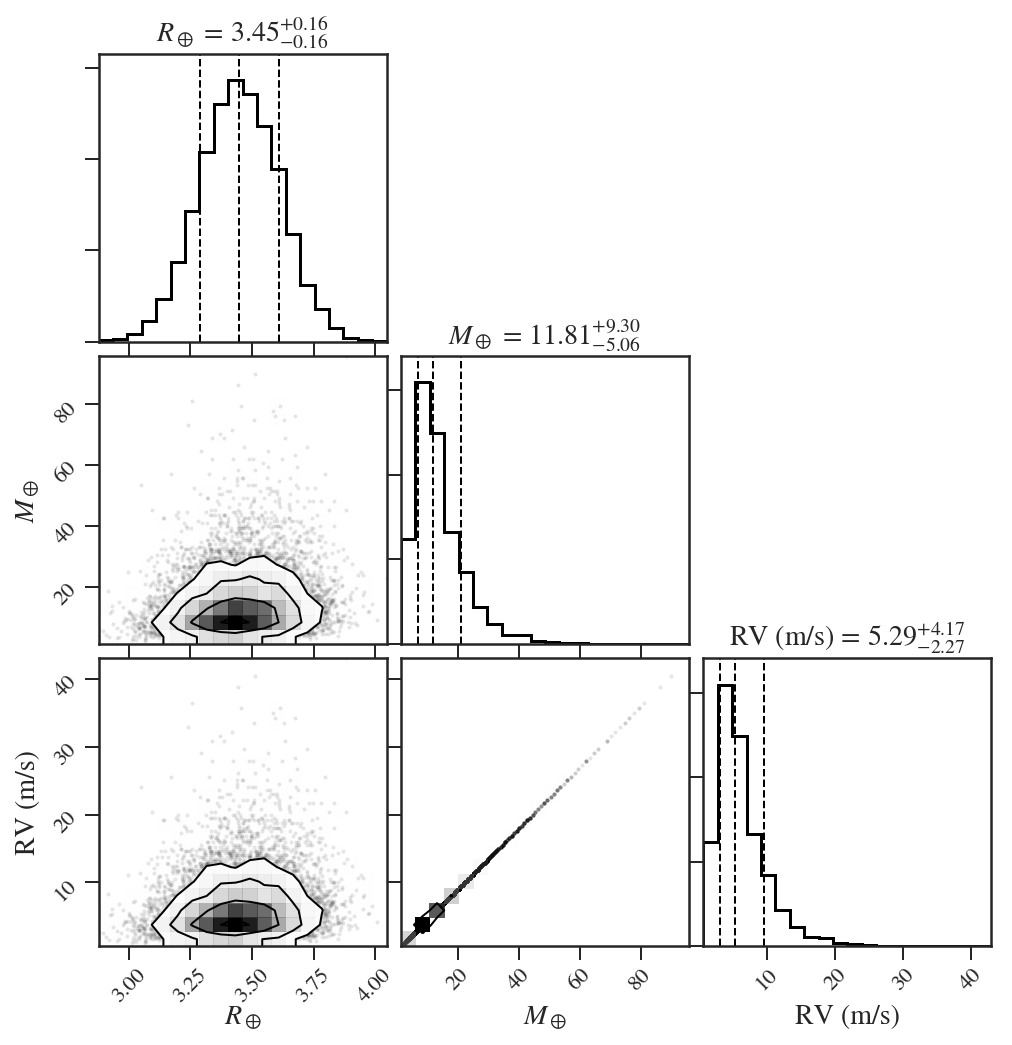

In [9]:
# K2-100b values
pl_rade      = 3.45
pl_radeerr1  = 0.16
pl_orbincl   = 87.3
pl_orbecc    = 0.
pl_orbper    = 1.6739024
st_mass      = 1.19

# Classify
r_post, m_post = predict_mass_from_radius_posterior(pl_rade=pl_rade, pl_radeerr1=pl_radeerr1,classify="Yes",plot=False)

# Generate RV posterior plot
r_post, m_post, rv_post, fig = get_predicted_rv_semiamplitude_posteriors(pl_rade=pl_rade,
                                          pl_radeerr1=pl_radeerr1,
                                          pl_orbper=pl_orbper,
                                          pl_orbincl=pl_orbincl,
                                          pl_orbecc=pl_orbecc,
                                          st_mass=st_mass)